<h3> Create and Save a Barscan Calibration for Main, Wing, and Midrange detector</h3>

Most relevant function here is [calculate_barscan_calibration](http://docs.drt-sans.ornl.gov/drtsans/pixel_calibration.html#drtsans.pixel_calibration.calculate_barscan_calibration).

The output of <code>calculate_barscan_calibration</code> outputs an object containing two parts: a <b>metadata</b> (instrument name, day stamp, name of the double-detector-array), and the proper calibration data, contained in a Mantid <b>table</b> object.

In [1]:
from copy import deepcopy
import numpy as np
import os
import time
from mantid.simpleapi import LoadEventNexus, LoadNexus, SaveNexus
from drtsans.mono.biosans import calculate_barscan_calibration, as_intensities, plot_detector
from drtsans.pixel_calibration import Table

#
# "plot_main_detector", "plot_wing_detector", and "plot_midrange_detector" are used to plot both detectors separately
#
%matplotlib inline
from matplotlib import pyplot as plt
def plot_main_detector(input_workspace, axes_mode='xy', panel_name='detector1', title='detector1'):
    return plot_detector(input_workspace, backend='mpl',axes_mode=axes_mode,
                         panel_name=panel_name, imshow_kwargs={})
def plot_wing_detector(input_workspace, axes_mode='xy', panel_name='wing_detector', title='wing_detector'):
    return plot_detector(input_workspace, backend='mpl',axes_mode=axes_mode,
                         panel_name=panel_name, imshow_kwargs={})
def plot_midrange_detector(input_workspace, axes_mode='xy', panel_name='midrange_detector',
                           title='midrange_detector'):
    return plot_detector(input_workspace, backend='mpl',axes_mode=axes_mode,
                         panel_name=panel_name, imshow_kwargs={})
def plot_workspace(input_workspace, axes_mode='xy'):
    return plot_detector(input_workspace, backend='mpl',axes_mode=axes_mode, imshow_kwargs={})

The barscan files we'll use are runs 22487 to 22601.

To save memory, I <b>integrated all events</b> in a given pixel into a single scalar representing the total number of counts. The processed data is saved onto files which are much quicker to load when calculating the calibration, and have an appropriate embedded file.

The original files lack the midrange detector. Hence, we clone the intensities of the first 32 front tubes and the first 32 back tubes onto the midrange detector.

The script that I used for this task is commented below. It takes a long time to run and it's not necessary to run it again.

In [2]:
"""
from drtsans.mono.biosans.simulated_intensities import clone_component_intensities, insert_midrange_detector
from mantid.api import AnalysisDataService
from mantid.simpleapi import mtd, DeleteWorkspace, DeleteWorkspaces, Integration, LoadEventNexus, SaveNexus
import os

data_dir = '/HFIR/CG3/IPTS-32383/nexus/'
first_run, last_run = 22487, 22601
target_dir = '/SNS/EQSANS/shared/sans-backend/data/ornl/sans/hfir/biosans/pixel_calibration/midrange_22487'
target_dir = '/SNS/users/gcs/Downloads/midrange_22487'
os.makedirs(target_dir, exist_ok=True)

remaining = 1 + last_run - first_run  # remaining files to process
for run in range(first_run, 1 + last_run):
    [DeleteWorkspace(name) for name in ['temporary', 'scan'] if AnalysisDataService.doesExist(name)]
    print('remaining files to process = ', remaining)
    file_path = os.path.join(data_dir, f'CG3_{run}.nxs.h5')
    outfile_path = os.path.join(target_dir, f'CG3_{run}.nxs')
    LoadEventNexus(file_path, OutputWorkspace='temporary', LoadNexusInstrumentXML=False)
    Integration(InputWorkspace='temporary', OutputWorkspace='temporary')
    insert_midrange_detector('temporary', output_workspace='scan')
    clone_component_intensities('scan', input_component="wing_detector", output_component="midrange_detector")
    SaveNexus('scan', Filename=outfile_path)
    remaining -= 1
[DeleteWorkspace(name) for name in ['temporary', 'scan'] if AnalysisDataService.doesExist(name)]
"""

'\nfrom drtsans.mono.biosans.simulated_intensities import clone_component_intensities, insert_midrange_detector\nfrom mantid.api import AnalysisDataService\nfrom mantid.simpleapi import mtd, DeleteWorkspace, DeleteWorkspaces, Integration, LoadEventNexus, SaveNexus\nimport os\n\ndata_dir = \'/HFIR/CG3/IPTS-32383/nexus/\'\nfirst_run, last_run = 22487, 22601\ntarget_dir = \'/SNS/EQSANS/shared/sans-backend/data/ornl/sans/hfir/biosans/pixel_calibration/midrange_22487\'\ntarget_dir = \'/SNS/users/gcs/Downloads/midrange_22487\'\nos.makedirs(target_dir, exist_ok=True)\n\nremaining = 1 + last_run - first_run  # remaining files to process\nfor run in range(first_run, 1 + last_run):\n    [DeleteWorkspace(name) for name in [\'temporary\', \'scan\'] if AnalysisDataService.doesExist(name)]\n    print(\'remaining files to process = \', remaining)\n    file_path = os.path.join(data_dir, f\'CG3_{run}.nxs.h5\')\n    outfile_path = os.path.join(target_dir, f\'CG3_{run}.nxs\')\n    LoadEventNexus(file_pat

In [3]:
data_dir = "/SNS/EQSANS/shared/sans-backend/data/ornl/sans/hfir/biosans/pixel_calibration/midrange_22487"
first_run, last_run = 22487, 22601
barscan_files = [os.path.join(data_dir, f'CG3_{run}.nxs') for run in range(first_run, 1 + last_run)]

# Calibrating the main detetor requires all files, but the wing and midrange detector don't need the last 10 files
barscan_main_files = barscan_files
barscan_wing_files = barscan_files[: -10]
barscan_midrange_files = barscan_wing_files

### Loading and Plotting one of the Scans
Let's plot the middle scan, run 22544, which is index 57 in the <code>barscan_files</code> list.

ISISRunLogs-[Warning] Cannot find period log. Logs will be not be filtered by current period
ISISRunLogs-[Warning] Cannot find periods log. Logs will be not be filtered by current period


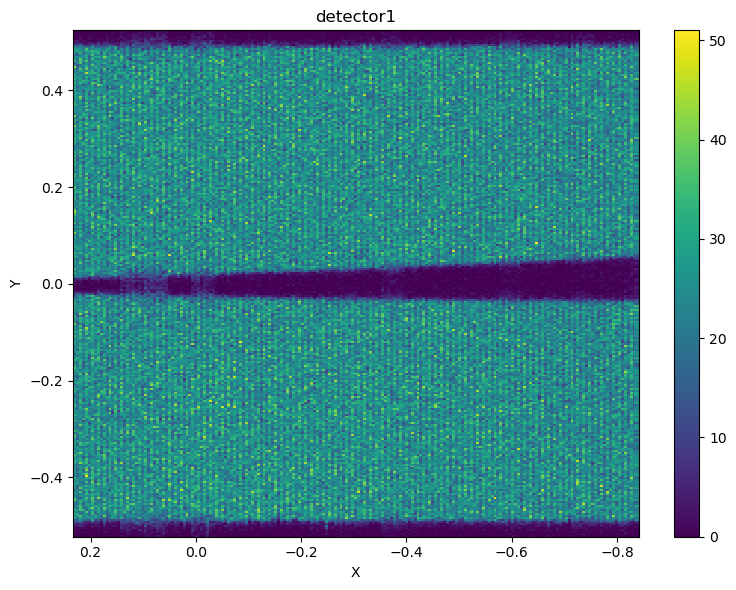

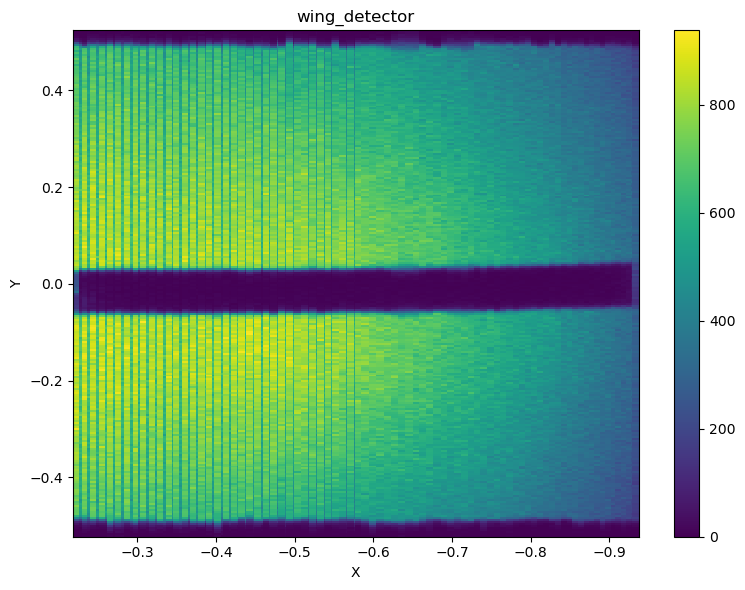

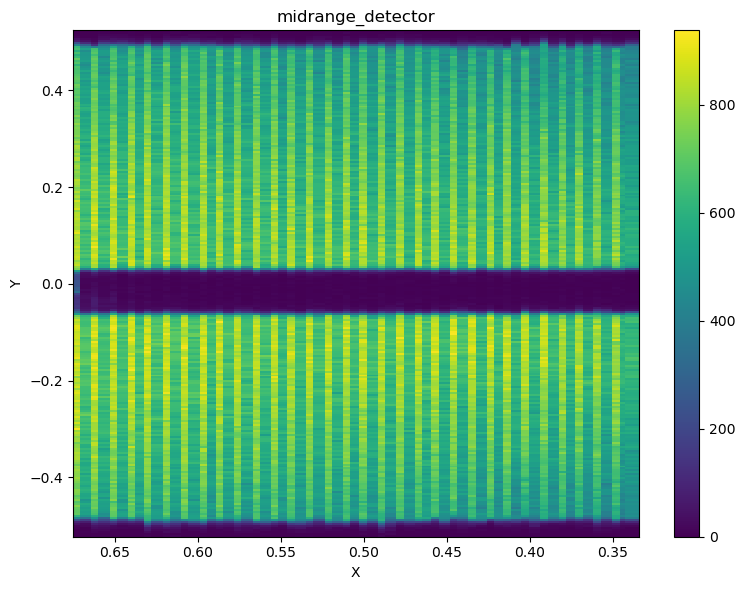

In [4]:
LoadNexus(barscan_files[57], OutputWorkspace='CG3_22544')
plot_main_detector('CG3_22544')
plot_wing_detector('CG3_22544')
plot_midrange_detector('CG3_22544')

### Masking  

Notice the <b>last tube of the wing detector</b> is partically covered by the bar. Thus, we will <b>mask this tube</b> when calibrating the wing detector. We alread have a mask file for this purpose.

Now we carry out the calibration of the **main** and **wing** detectors. Each detector array requires its own calibration.

### Position of the Bar

We require formulas for the position of the bar:
- **main** `formula='{y} - 565'`
- **wing**: `formula='{y} - 565'`
- **midrange**: `formula='{y} - 565'`

Here, `{y}` is the value of log entry `dcal_Reaback` for the main detector and `ww_dcal_Readback` for the wing detector. The value is maximal when the bar is at the top of the detector, then decreases as we move the bar down. It is recommended to check the value of `dcal_Readback` when the bar is at the top of the detector to confirm the value corresponds to the maximal value in the scan series.

We will later assess the validity of these formulas by analyzing the results of the calibration

### Calibration Function

We use function [calculate_barscan_calibration](https://scse.ornl.gov/docs/drt/sans/drtsans/pixel_calibration.html#drtsans.pixel_calibration.calculate_barscan_calibration)

In [5]:
# CALIBRATE THE MAIN DECTECTOR
start_time = time.time()
calibration_main = calculate_barscan_calibration(barscan_main_files, component='detector1',
                                                 bar_position_log='dcal_Readback', formula='{y} - 565')
print('Calibration of the main detector array took ', int((time.time() - start_time) / 60), 'minutes')

ISISRunLogs-[Warning] Cannot find period log. Logs will be not be filtered by current period
ISISRunLogs-[Warning] Cannot find periods log. Logs will be not be filtered by current period
ISISRunLogs-[Warning] Cannot find period log. Logs will be not be filtered by current period
ISISRunLogs-[Warning] Cannot find periods log. Logs will be not be filtered by current period
ISISRunLogs-[Warning] Cannot find period log. Logs will be not be filtered by current period
ISISRunLogs-[Warning] Cannot find periods log. Logs will be not be filtered by current period
ISISRunLogs-[Warning] Cannot find period log. Logs will be not be filtered by current period
ISISRunLogs-[Warning] Cannot find periods log. Logs will be not be filtered by current period
ISISRunLogs-[Warning] Cannot find period log. Logs will be not be filtered by current period
ISISRunLogs-[Warning] Cannot find periods log. Logs will be not be filtered by current period
ISISRunLogs-[Warning] Cannot find period log. Logs will be not be

In [6]:
# CALIBRATE THE WING DETECTOR
mask_file = '/SNS/EQSANS/shared/sans-backend/data/ornl/sans/hfir/biosans/pixel_calibration/midrange_5767/biosans_mask_bank88_tube4.xml'
start_time = time.time()
calibration_wing = calculate_barscan_calibration(barscan_wing_files, component='wing_detector',
                                                 bar_position_log='ww_dcal_Readback', formula='{y} - 565',
                                                 mask=mask_file)
print('Calibration of the wing detector array took ', int((time.time() - start_time) / 60), 'minutes')

ISISRunLogs-[Warning] Cannot find period log. Logs will be not be filtered by current period
ISISRunLogs-[Warning] Cannot find periods log. Logs will be not be filtered by current period
ISISRunLogs-[Warning] Cannot find period log. Logs will be not be filtered by current period
ISISRunLogs-[Warning] Cannot find periods log. Logs will be not be filtered by current period
ISISRunLogs-[Warning] Cannot find period log. Logs will be not be filtered by current period
ISISRunLogs-[Warning] Cannot find periods log. Logs will be not be filtered by current period
ISISRunLogs-[Warning] Cannot find period log. Logs will be not be filtered by current period
ISISRunLogs-[Warning] Cannot find periods log. Logs will be not be filtered by current period
ISISRunLogs-[Warning] Cannot find period log. Logs will be not be filtered by current period
ISISRunLogs-[Warning] Cannot find periods log. Logs will be not be filtered by current period
ISISRunLogs-[Warning] Cannot find period log. Logs will be not be

In [7]:
# CALIBRATE THE MIDRANGE DETECTOR
start_time = time.time()
calibration_midrange = calculate_barscan_calibration(barscan_midrange_files, component='midrange_detector',
                                                     bar_position_log='ww_dcal_Readback', formula='{y} - 565')
print('Calibration of the midrange_detector detector array took ', int((time.time() - start_time) / 60), 'minutes')

ISISRunLogs-[Warning] Cannot find period log. Logs will be not be filtered by current period
ISISRunLogs-[Warning] Cannot find periods log. Logs will be not be filtered by current period
ISISRunLogs-[Warning] Cannot find period log. Logs will be not be filtered by current period
ISISRunLogs-[Warning] Cannot find periods log. Logs will be not be filtered by current period
ISISRunLogs-[Warning] Cannot find period log. Logs will be not be filtered by current period
ISISRunLogs-[Warning] Cannot find periods log. Logs will be not be filtered by current period
ISISRunLogs-[Warning] Cannot find period log. Logs will be not be filtered by current period
ISISRunLogs-[Warning] Cannot find periods log. Logs will be not be filtered by current period
ISISRunLogs-[Warning] Cannot find period log. Logs will be not be filtered by current period
ISISRunLogs-[Warning] Cannot find periods log. Logs will be not be filtered by current period
ISISRunLogs-[Warning] Cannot find period log. Logs will be not be

In [8]:
# QUICK SANITY CHECK
print('Pixel Heights (meters):')
print(f'    in Main Detector: min = {min(calibration_main.heights):.4f}, max = {max(calibration_main.heights):.4f}')
print(f'    in Wing Detector: min = {min(calibration_wing.heights):.4f}, max = {max(calibration_wing.heights):.4f}')
print(f'    in Midrange Detector: min = {min(calibration_midrange.heights):.4f}, max = {max(calibration_midrange.heights):.4f}')

print('Pixel Vertical Positions (meters):')
print(f'    in Main Detector: min = {min(calibration_main.positions):.4f}, max = {max(calibration_main.positions):.4f}')
print(f'    in Wing Detector: min = {min(calibration_wing.positions):.4f}, max = {max(calibration_wing.positions):.4f}')
print(f'    in Midrange Detector: min = {min(calibration_midrange.positions):.4f}, max = {max(calibration_midrange.positions):.4f}')

Pixel Heights (meters):
    in Main Detector: min = 0.0023, max = 0.0057
    in Wing Detector: min = 0.0039, max = 0.0047
    in Midrange Detector: min = 0.0039, max = 0.0047
Pixel Vertical Positions (meters):
    in Main Detector: min = -0.5343, max = 0.6032
    in Wing Detector: min = -0.5879, max = 0.5086
    in Midrange Detector: min = -0.5877, max = 0.5086


### Visualizing the Calibrations

We first apply the calibrations to the file we loaded previously into workspace `CG3_22544`. We use method [apply]() to generate a calibrated workspace `CG3_22544_calibrated`

In [9]:
calibration_main.apply('CG3_22544', output_workspace='CG3_22544_calibrated')
calibration_wing.apply('CG3_22544_calibrated')
calibration_midrange.apply('CG3_22544_calibrated')

Workspace2D
Title: Barscan 58
Histograms: 106496
Bins: 1
Histogram
X axis: Time-of-flight / microsecond
Y axis: Counts
Distribution: False
Instrument: BIOSANS (2023-Oct-01 to 2100-Dec-31)Instrument from: /SNS/EQSANS/shared/sans-backend/data/ornl/sans/hfir/biosans/pixel_calibration/midrange_22487/CG3_22544.nxs

Run start: 2024-Jan-19 04:11:37
Run end:  2024-Jan-19 04:13:17

Then we generate "views" of the calibrated pixels with function [as_intensities](https://scse.ornl.gov/docs/drt/sans/drtsans/pixel_calibration.html#drtsans.pixel_calibration.as_intensities). The views are two new workspaces: `views.heights` and `views.positions`. The intensities at the detector pixels of `views.heights` correspond to the heights of the detector. Thus, we can plot these "intensities" in a 2D plot of the main and wing detector array.

In [10]:
views = as_intensities('CG3_22544_calibrated', component=['detector1', 'wing_detector', 'midrange_detector'])

The views can be plotted for each detector. We plot pixel **heights** and **positions**

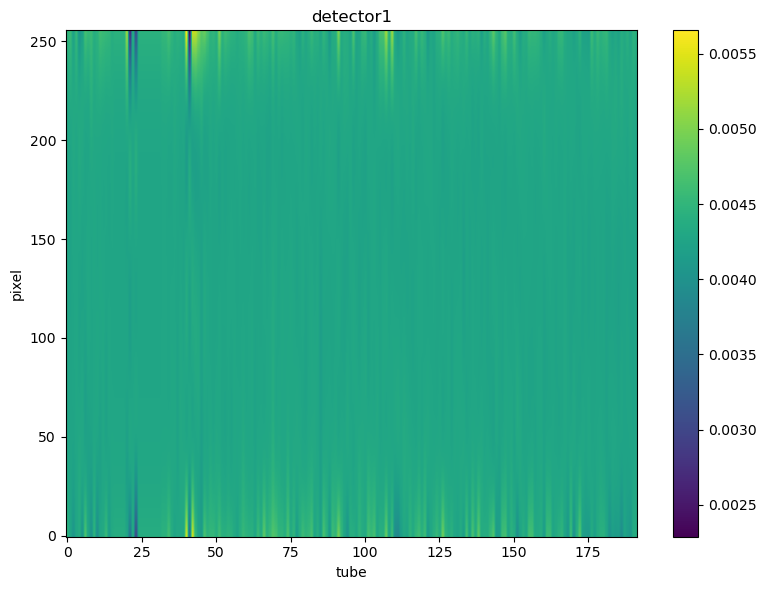

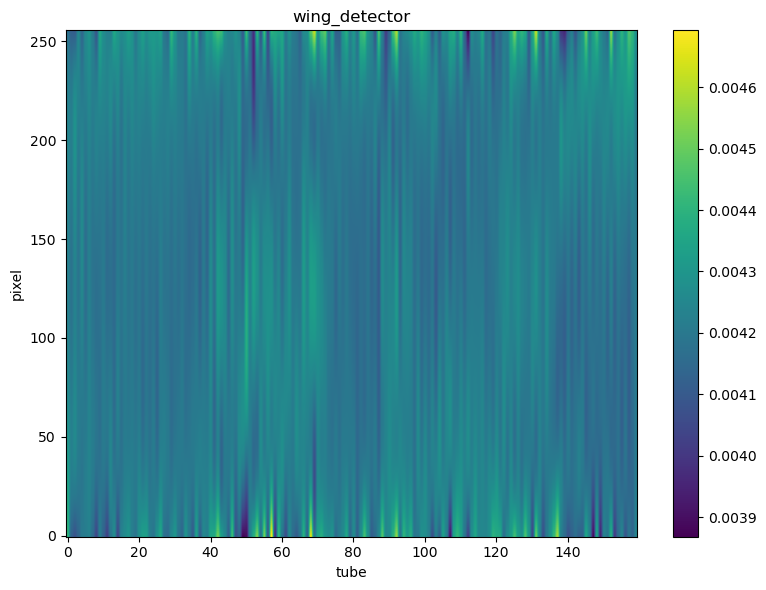

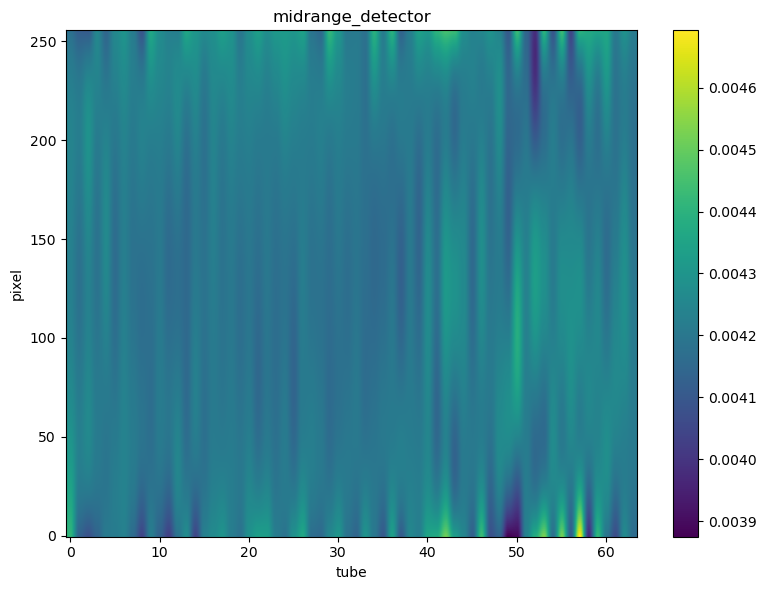

In [11]:
plot_main_detector(views.heights, axes_mode='tube-pixel')
plot_wing_detector(views.heights, axes_mode='tube-pixel')
plot_midrange_detector(views.heights, axes_mode='tube-pixel')

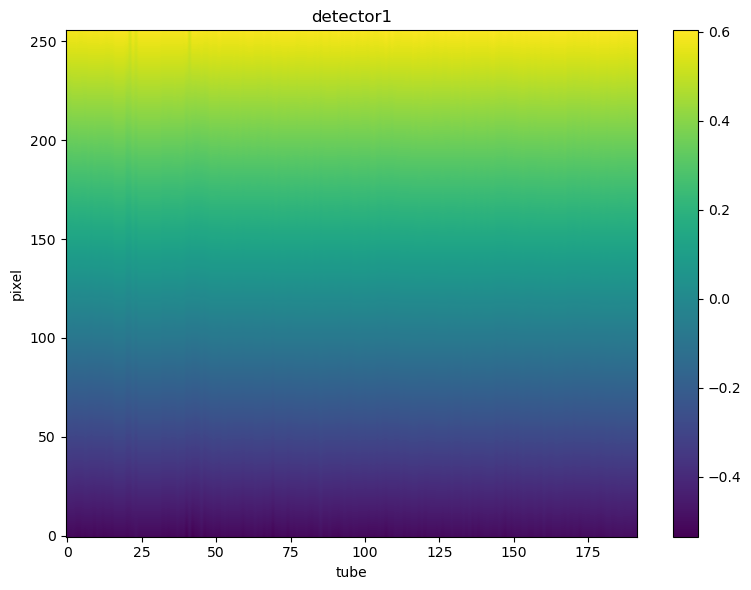

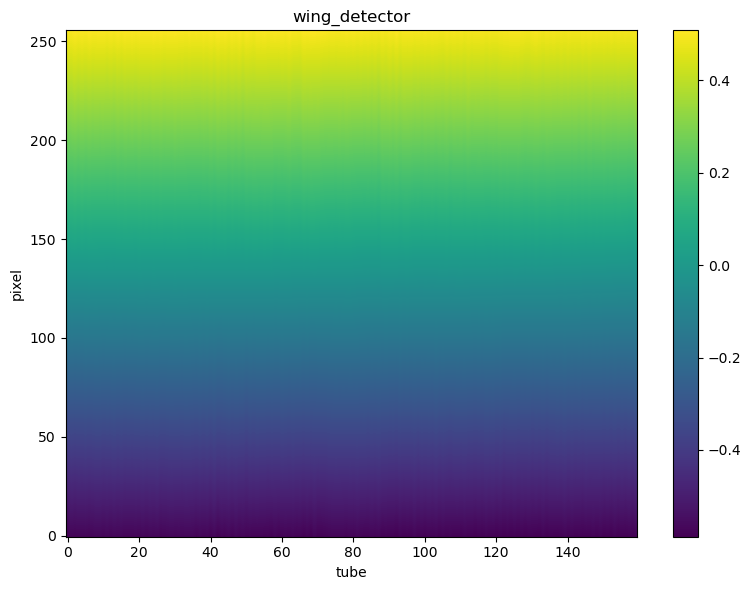

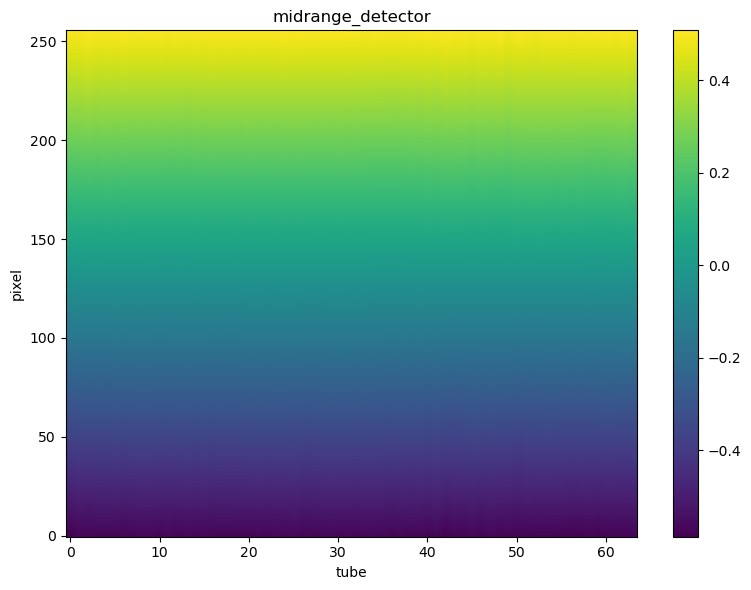

In [12]:
plot_main_detector(views.positions, axes_mode='tube-pixel')
plot_wing_detector(views.positions, axes_mode='tube-pixel')
plot_midrange_detector(views.positions, axes_mode='tube-pixel')

Finally, we save these views as worskpaces which can be loaded into Mantid and visualized with the Instrument Viewer

In [13]:
SaveNexus(views.heights, '/tmp/pixel_heights.nxs')
SaveNexus(views.positions, '/tmp/pixel_positions.nxs')

### Analyzing the Calibrations

We first compare the middle barscan run before and after we apply the calibration

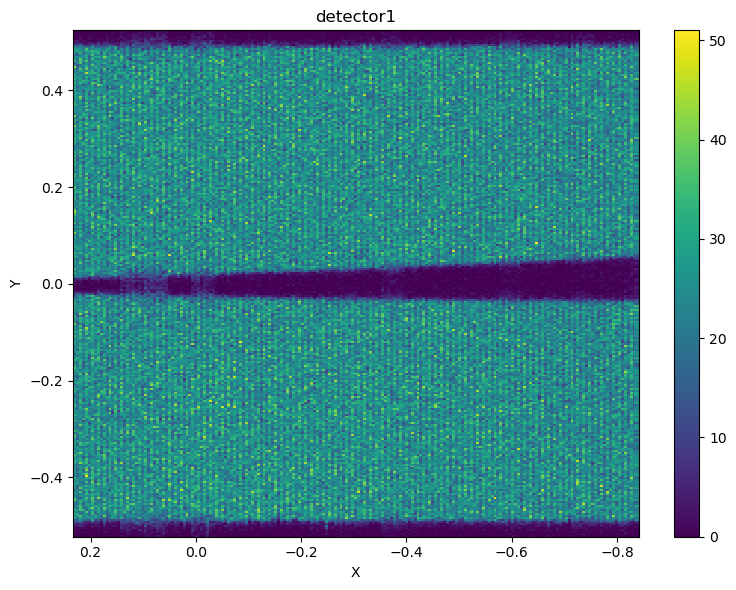

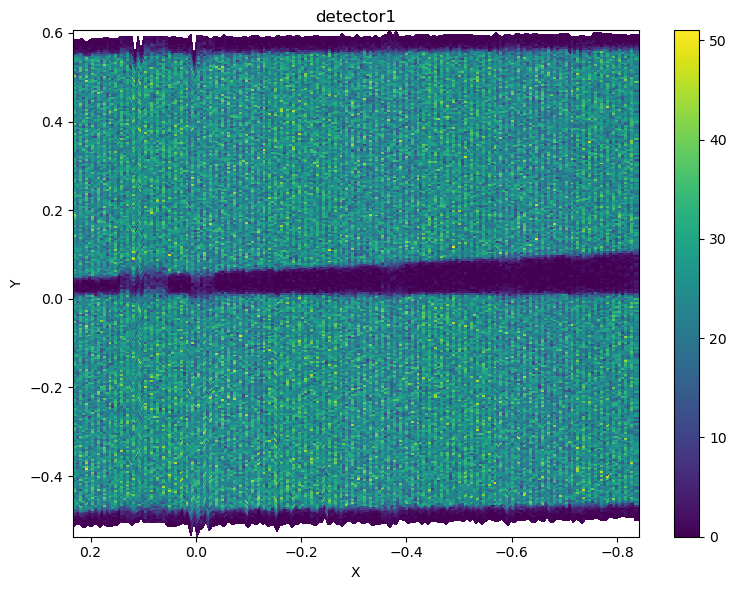

In [14]:
plot_main_detector('CG3_22544')  # before calibration
plot_main_detector('CG3_22544_calibrated')

Two observations:

1. The vertical position of the center of mass for the detector after calibration seem to lie on positive `Y` values. That would indicate that `595` was not the correct value for the position of the bar formula='{y} - 565'.
2. After calibration, the position of the top and bottom pixels seem to increase with coordinate `X`, which may indicate a slightly tilt of the bottom edge of the bar

### Location of the Vertical Position of the Center of Mass


In [15]:
cm = 1000 * np.mean(calibration_main.positions)
print('Vertical position of the Center of Mass = ', cm, 'mili meters')
print('New offset = ', 565 + cm / 2, 'mili meters')

Vertical position of the Center of Mass =  42.908746717694214 mili meters
New offset =  586.4543733588471 mili meters


### Analyzing the possible bar tilt

We'll look at the variation in the position of the top and bottom pixels as a function of tube index. We perform a linear regression of this variation.

top  pixels:
    slope = 0.060 mili-meters / tube
    position difference between last and first tube = 11.540 mili-meters
bottom  pixels:
    slope = 0.082 mili-meters / tube
    position difference between last and first tube = 15.676 mili-meters


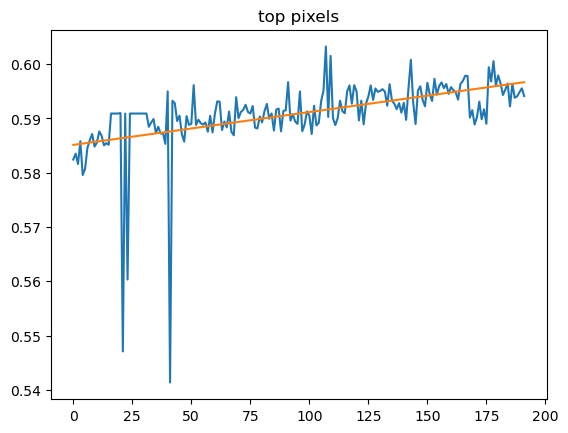

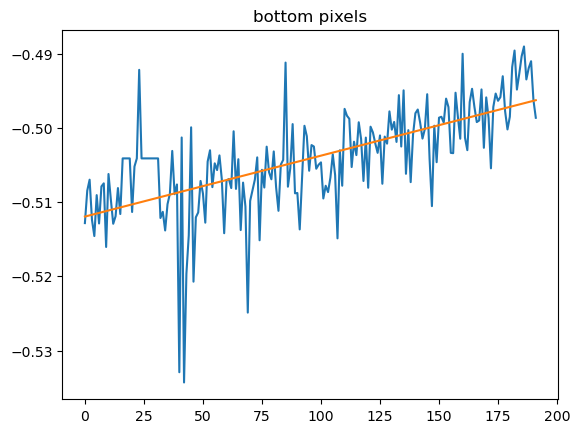

In [16]:
def report_tilt(pixel_positions):

    # Create a 2D array of pixel heights, dimensions are (number_tubes x pixels_in_tube)
    pixel_in_tube_count = 256
    tube_count = int(len(pixel_positions) / pixel_in_tube_count)
    positions = np.array(pixel_positions).reshape((tube_count, pixel_in_tube_count))

    def fit(tube_tip_positions):
        r"""This function will fit the bottom or top pixels against the tube index"""
        tube_indexes = np.arange(tube_count)  # heights as function of tube index
        coeffs = np.polyfit(tube_indexes, tube_tip_positions, 1)
        fitted = np.poly1d(coeffs)(tube_indexes)  # fitted positions of the tube tip
        return coeffs, fitted

    for location, tip_positions in (['top', positions[:, -1]], ['bottom', positions[:, 0]]):
        coeffs, fitted = fit(tip_positions)  # fit against tube index
        # Plot the raw positions and the fitted positions
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        ax.plot(np.arange(tube_count), tip_positions)
        ax.plot(np.arange(tube_count), fitted)
        ax.set_title(f'{location} pixels')
        # Print a few representative properties of the tilt
        print(location, ' pixels:')
        print(f'    slope = {1000 * coeffs[0]:.3f} mili-meters / tube')
        print(f'    position difference between last and first tube = {1000 * (fitted[-1] - fitted[0]):.3f} mili-meters')

report_tilt(calibration_main.positions)

### Removing the Bar Tilt and Centering the Detector

Thinking of the fitted positions for the bottom and top pixels, we can think of the detector array as a deformed rectangle (angles between sides different than 90 degrees), which must be transformed into a rectangle with squared angles (angles between sides equal to 90 degrees).

We take the tube in the middle of the main detector array as our reference. We will adjust every other tube so that for every tube, its top and bottom *fitted* pixel positions will coincide with the top and bottom *fitted* positions of the middle tube.

Also, since top and bottom fitted positions have a different variation with tube index, the fitted tube lenght changes sligtly with tube index. Thus, we will rescale the fitted tube length to coincide with the fitted tube length of the middle tube. This amounts to a rescaling of pixel heights.

Finally, after removing the tilt we displace the detector so that the center of mass lies at `Y=0`.

In [17]:
def untilt_and_center(calibration):
    # Create a 2D array of pixel heights, dimensions are (number_tubes x pixels_in_tube)
    pixel_in_tube_count = 256
    tube_count = int(len(calibration.positions) / pixel_in_tube_count)
    positions = np.array(calibration.positions).reshape((tube_count, pixel_in_tube_count))
    heights = np.array(calibration.heights).reshape((tube_count, pixel_in_tube_count))

    def fit(tube_tip_positions):
        r"""This function will fit the bottom or top pixels against the tube index"""
        tube_indexes = np.arange(tube_count)  # heights as function of tube index
        coeffs = np.polyfit(tube_indexes, tube_tip_positions, 1)
        fitted = np.poly1d(coeffs)(tube_indexes)  # fitted positions of the tube tip
        return coeffs, fitted

    _, fitted_top = fit(positions[:, -1])  # fitted positions of the tube tops
    _, fitted_bottom = fit(positions[:, 0])  # fitted positions of the tube bottom
    # We'll adjust the positions of the tubes to comply with the middle tube
    tube_reference_index = int(tube_count / 2)  # tube in the middle of the detector
    tube_length_reference = fitted_top[tube_reference_index] - fitted_bottom[tube_reference_index]
    # shifts_top indicate the difference in fitted positions for the tube tops with respect to the fitted positions
    # for the top of the middle tube
    shifts_top = fitted_top[tube_reference_index] - fitted_top
    shifts_bottom = fitted_bottom[tube_reference_index] - fitted_bottom
    # Calculate now the shifts for every single pixel, going tube by tube
    pixel_indexes = np.arange(pixel_in_tube_count)
    shifts = list()
    scalings = list()
    for tube_index in range(tube_count):
        a, b = shifts_bottom[tube_index], shifts_top[tube_index]
        shifts_in_tube =  a + (b - a) * pixel_indexes / pixel_in_tube_count
        shifts.append(shifts_in_tube)
        tube_length = fitted_top[tube_index] - fitted_bottom[tube_index]
        scalings_in_tube = [tube_length_reference / tube_length] * pixel_in_tube_count
        scalings.append(scalings_in_tube)

    positions_new = positions + np.array(shifts)
    heights_new = heights * np.array(scalings)

    # Set CM at y=0
    positions_new -= np.mean(positions.ravel())

    # retrieve components from the main calibration in order to construct a new calibration
    metadata = deepcopy(calibration.metadata)
    detector_ids = deepcopy(calibration.detector_ids)
    recalibration = Table(metadata,
                          detector_ids=detector_ids,
                          positions=positions_new.ravel(),
                          heights=heights_new.ravel())
    return recalibration

calibration_main = untilt_and_center(calibration_main)

Applying the adjusted calibration should create a centered detector with no dependence on tube index.

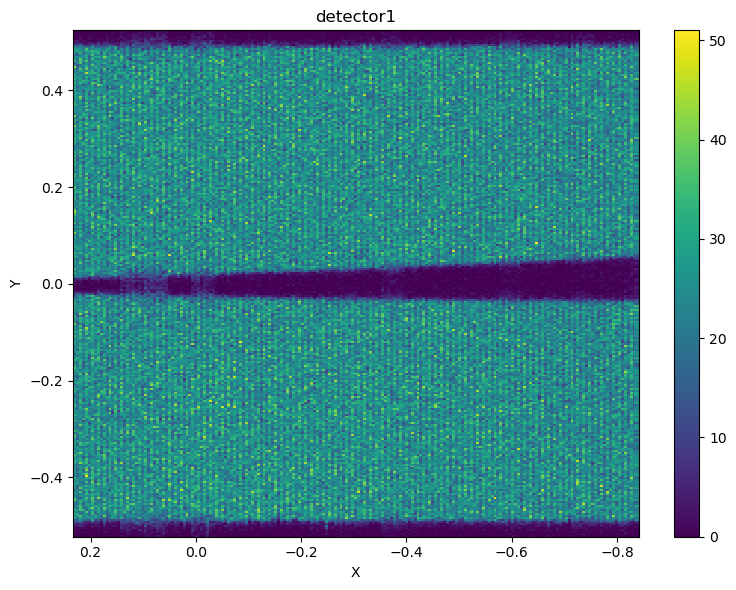

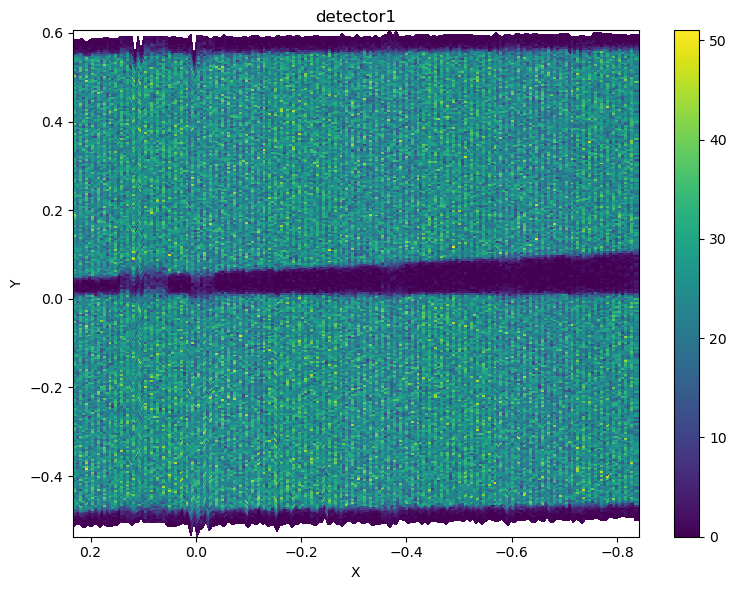

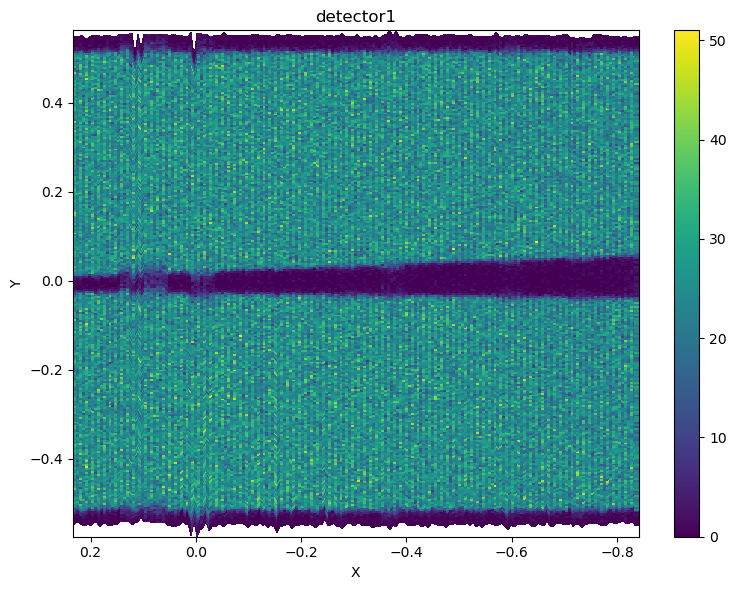

In [18]:
calibration_main.apply('CG3_22544', output_workspace='CG3_22544_recalibrated')
plot_main_detector('CG3_22544')  # before calibration
plot_main_detector('CG3_22544_calibrated')  # calibrated, not adjusted
plot_main_detector('CG3_22544_recalibrated')  # calibrated and adjusted

We verify the top and bottom pixels of the recalibration do not have a dependence on tube index

top  pixels:
    slope = -0.000 mili-meters / tube
    position difference between last and first tube = -0.016 mili-meters
bottom  pixels:
    slope = 0.000 mili-meters / tube
    position difference between last and first tube = 0.000 mili-meters


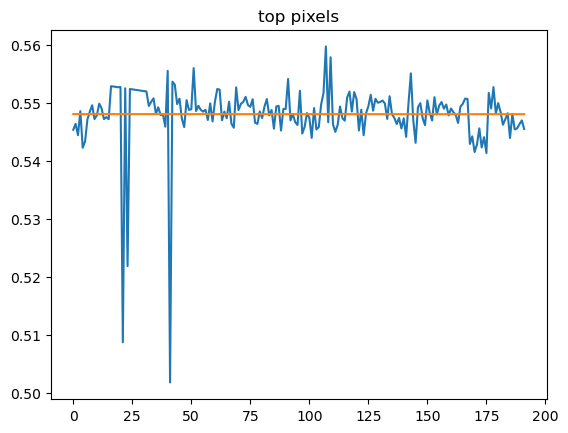

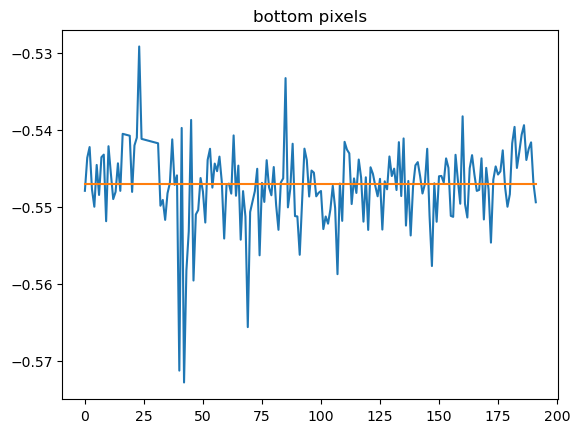

In [19]:
report_tilt(calibration_main.positions)

We run a similar analysis on the wing_detector

In [20]:
calibration_wing = untilt_and_center(calibration_wing)  # adjust the wing calibration
calibration_wing.apply('CG3_22544_recalibrated')  # apply it to our recalibrated workspace

Workspace2D
Title: Barscan 58
Histograms: 106496
Bins: 1
Histogram
X axis: Time-of-flight / microsecond
Y axis: Counts
Distribution: False
Instrument: BIOSANS (2023-Oct-01 to 2100-Dec-31)Instrument from: /SNS/EQSANS/shared/sans-backend/data/ornl/sans/hfir/biosans/pixel_calibration/midrange_22487/CG3_22544.nxs

Run start: 2024-Jan-19 04:11:37
Run end:  2024-Jan-19 04:13:17

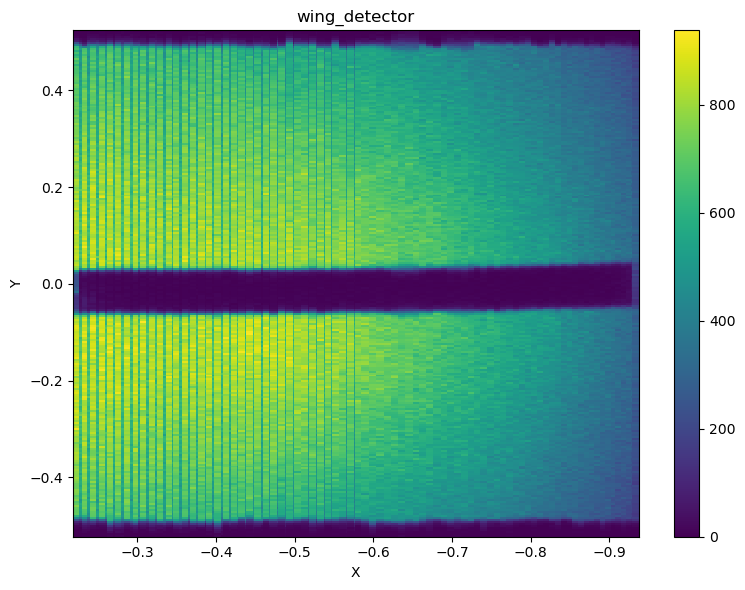

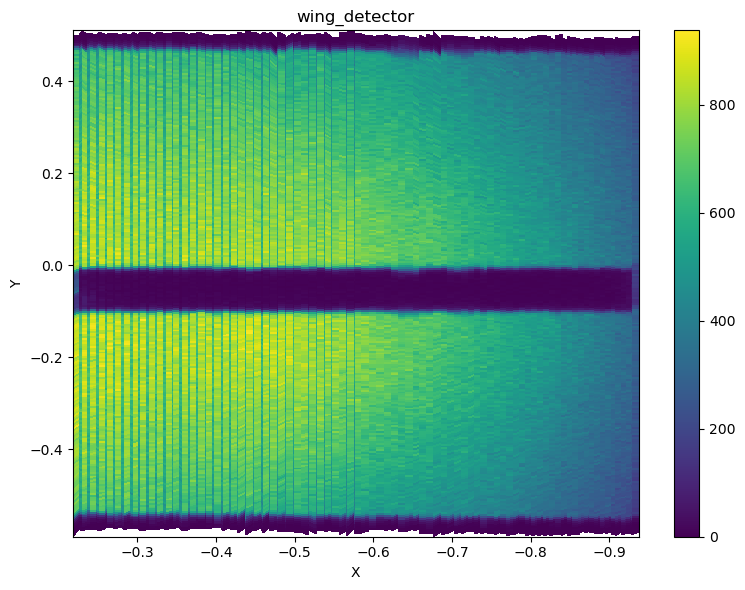

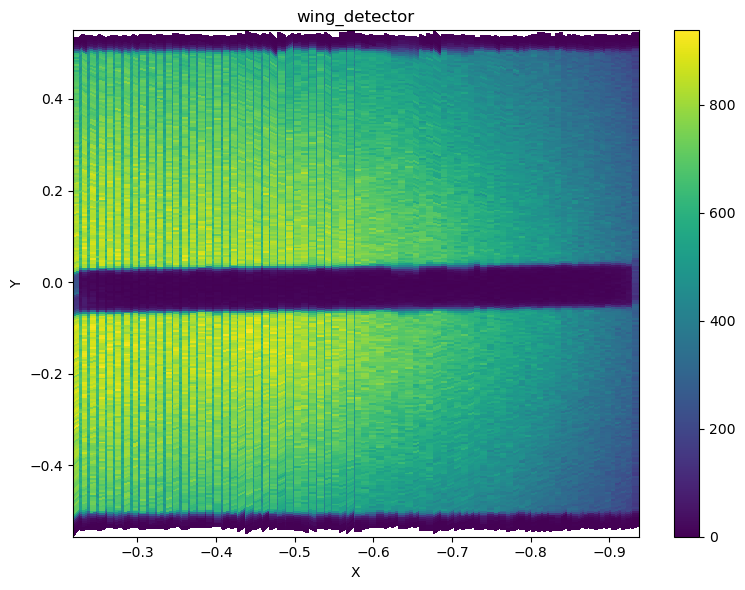

In [21]:
plot_wing_detector('CG3_22544')  # before calibration
plot_wing_detector('CG3_22544_calibrated')  # after calibration
plot_wing_detector('CG3_22544_recalibrated')  # calibrated and adjusted

We run a similar analysis on the Midrange detector

In [22]:
calibration_midrange = untilt_and_center(calibration_midrange)  # adjust the wing calibration
calibration_midrange.apply('CG3_22544_recalibrated')  # apply it to our recalibrated workspace

Workspace2D
Title: Barscan 58
Histograms: 106496
Bins: 1
Histogram
X axis: Time-of-flight / microsecond
Y axis: Counts
Distribution: False
Instrument: BIOSANS (2023-Oct-01 to 2100-Dec-31)Instrument from: /SNS/EQSANS/shared/sans-backend/data/ornl/sans/hfir/biosans/pixel_calibration/midrange_22487/CG3_22544.nxs

Run start: 2024-Jan-19 04:11:37
Run end:  2024-Jan-19 04:13:17

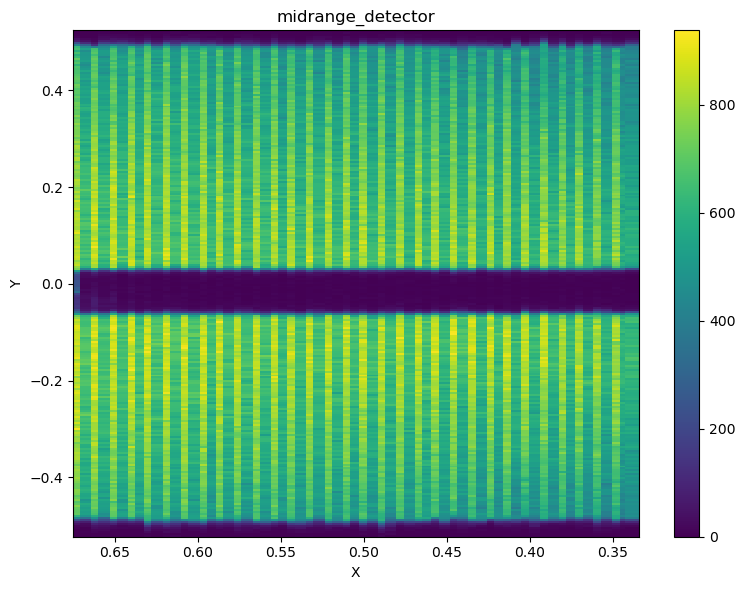

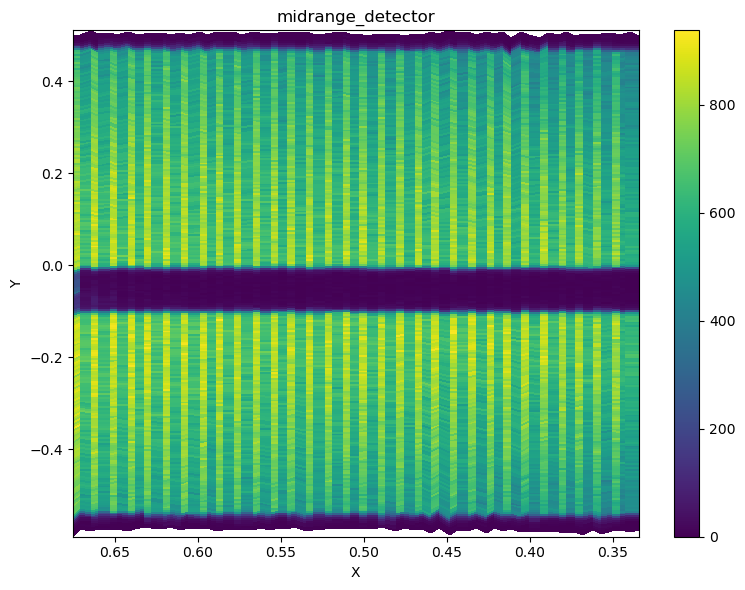

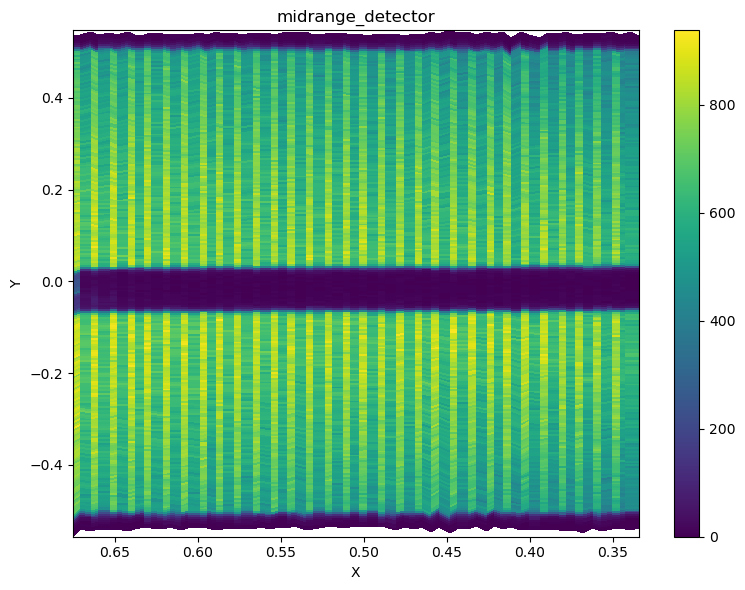

In [23]:
plot_midrange_detector('CG3_22544')  # before calibration
plot_midrange_detector('CG3_22544_calibrated')  # after calibration
plot_midrange_detector('CG3_22544_recalibrated')  # calibrated and adjusted

<h5>Calibration objects are saved to a database as two separate pieces:</h5>

- metadata (instrument name, day stamp, name of the double-detector-array) is save to a JSON file.  
- data (a table workspace) is saved to a Nexus file with SaveNexus.  

There's a default database for every instrument. The BIOSANS location for the metadata JSON file:

- BIOSANS: <b>/HFIR/CG3/shared/calibration/pixel_calibration.json</b>

Data tables are saved under `tables/` subdirectory:

- BIOSANS: <b>/HFIR/CG3/shared/calibration/tables</b>

<h5>Calibration objects have method "<b>save</b>" to save itself to the the database. The full signature of this method:</h5>

    def save(self, database=None, tablefile=None, overwrite=False):
        r"""
        Save the calibration metadata in a JSON file, and the calibration table workspace in a Nexus file.

        Parameters
        ----------
        database: str
            Path to the JSON file where the ```metadata``` dictionary will be appended. If :py:obj:`None`,
            then the appropriate default file from ~drtsans.pixel_calibration.database_file is used.
            Currently, these are the default files:
            - BIOSANS, '/HFIR/CG3/shared/calibration/pixel_calibration.json',
            - EQSANS, '/SNS/EQSANS/shared/calibration/pixel_calibration.json',
            - GPSANS, '/HFIR/CG2/shared/calibration/pixel_calibration.json'
        tablefile: str
            Path to the Nexus file storing the pixel calibration data. If :py:obj:`None`, then
            a composite name is created using the calibration type, instrument, component,
            and daystamp. (e.g. "barscan_biosans_detector1_20200311"). The file is saved under
            subdirectory 'tables', located within the directory of the ```database``` file.
            For instance, '/HFIR/CG3/shared/calibration/tables/barscan_biosans_detector1_20200311.nxs'
        overwrite: bool
            Substitute existing entry with same metadata

        Raises
        ------
        ValueError
            If we save a calibration already in the database with option ```overwrite=False```.
        """

In [24]:
calibration_main.save(database="/tmp/pixel_calibration.json", overwrite=True)  # save calibration for the main detector
calibration_wing.save(database="/tmp/pixel_calibration.json", overwrite=True)  # save calibration for the main detector
calibration_midrange.save(database="/tmp/pixel_calibration.json", overwrite=True)  # save calibration for the main detector

<h3>Load and Apply a Barscan Calibration</h3>

Most relevant function is [load_calibration](http://docs.drt-sans.ornl.gov/drtsans/pixel_calibration.html#drtsans.pixel_calibration.load_calibration)

In [25]:
import os
from mantid.simpleapi import LoadEventNexus
from drtsans.mono.biosans import load_calibration, plot_detector

#
# "plot_main_detector", "plot_wing_detector" and "plot_midrange_detector" are used to plot both detectors separately
#
%matplotlib inline
def plot_main_detector(input_workspace, axes_mode='xy', panel_name='detector1'):
    return plot_detector(input_workspace, backend='mpl',axes_mode=axes_mode,
                         panel_name=panel_name, imshow_kwargs={})
def plot_wing_detector(input_workspace, axes_mode='xy', panel_name='wing_detector'):
    return plot_detector(input_workspace, backend='mpl',axes_mode=axes_mode,
                         panel_name=panel_name, imshow_kwargs={})
def plot_midrange_detector(input_workspace, axes_mode='xy', panel_name='midrange_detector'):
    return plot_detector(input_workspace, backend='mpl',axes_mode=axes_mode,
                         panel_name=panel_name, imshow_kwargs={})
def plot_workspace(input_workspace, axes_mode='xy'):
    return plot_detector(input_workspace, backend='mpl',axes_mode=axes_mode, imshow_kwargs={})

Below we load the run to which we will apply the calibration to run 22544, scan number 57.

We take a look by plotting the pixel intensities on both main and wing detectors.

ISISRunLogs-[Warning] Cannot find period log. Logs will be not be filtered by current period
ISISRunLogs-[Warning] Cannot find periods log. Logs will be not be filtered by current period


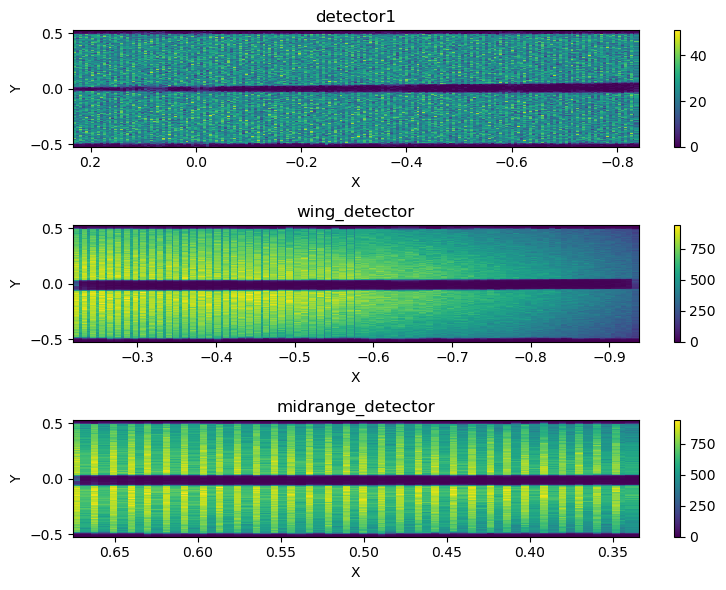

In [26]:
data_file = "/SNS/EQSANS/shared/sans-backend/data/ornl/sans/hfir/biosans/pixel_calibration/midrange_22487/CG3_22544.nxs"
LoadNexus(data_file, OutputWorkspace='CG3_22544')
plot_workspace('CG3_22544')

Loading a calibration with [load_calibration](http://docs.drt-sans.ornl.gov/drtsans/pixel_calibration.html#drtsans.pixel_calibration.load_calibration) requires at least a target workspace and the type of calibration to be loaded. Function <code>load_calibration</code> returns a calibration object.

The calibration object has method <b>apply</b> to apply itself into a target workspace. Here's the full documentation for this method:

    def apply(self, input_workspace, output_workspace=None):
        r"""
        Apply a calibration to an input workspace, and return the calibrated workspace.

        Parameters
        ----------
        input_workspace: str, ~mantid.api.MatrixWorkspace, ~mantid.api.IEventsWorkspace
            Workspace to which calibration needs to be applied.
        output_workspace: str
            Name of the output workspace with calibrated pixels. If :py:obj:`None`, the pixels
            of the input workspace will be calibrated and no new workspace is generated.

        Returns
        -------
        ~mantid.api.MatrixWorkspace, ~mantid.api.IEventsWorkspace
        """

In [27]:
start_time = time.time()
from drtsans.mono.biosans import apply_calibrations
apply_calibrations('CG3_22544', database="/tmp/pixel_calibration.json", calibrations='BARSCAN')  # apply only barscan (to main and wing detectors)
print(f'Applying the two calibrations took {time.time() - start_time:.1} seconds')

Applying the two calibrations took 0.1 seconds


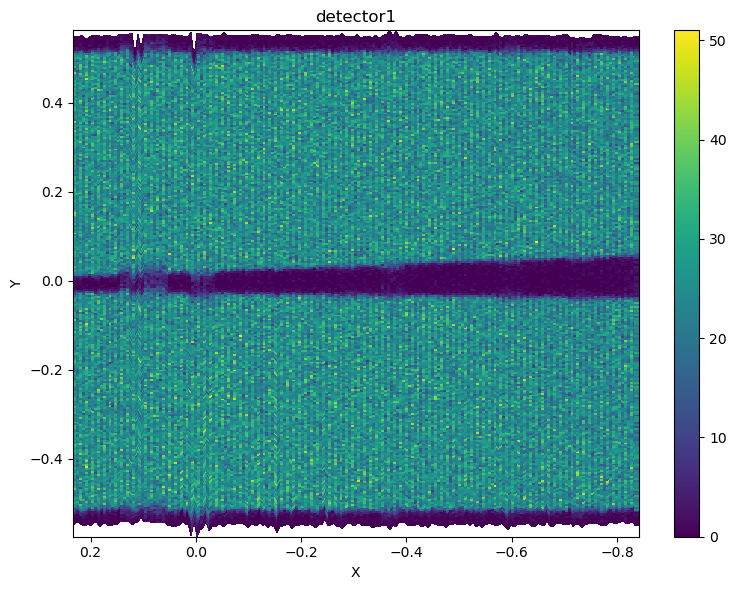

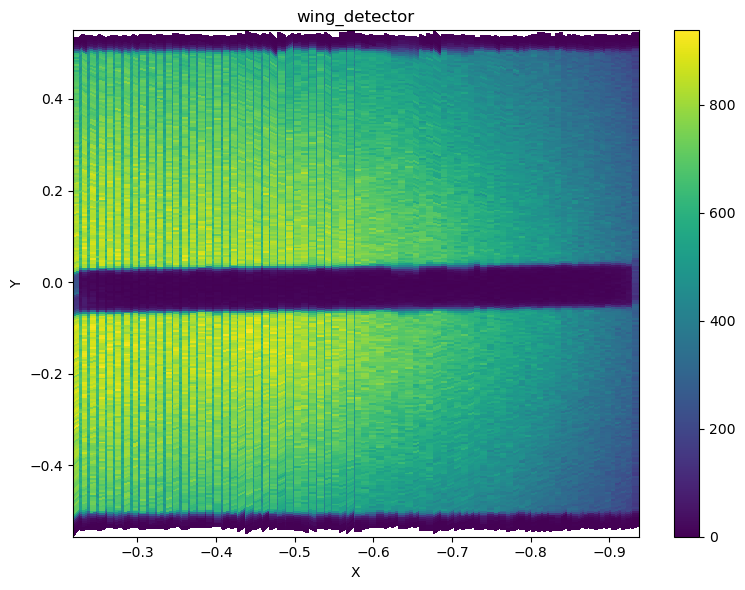

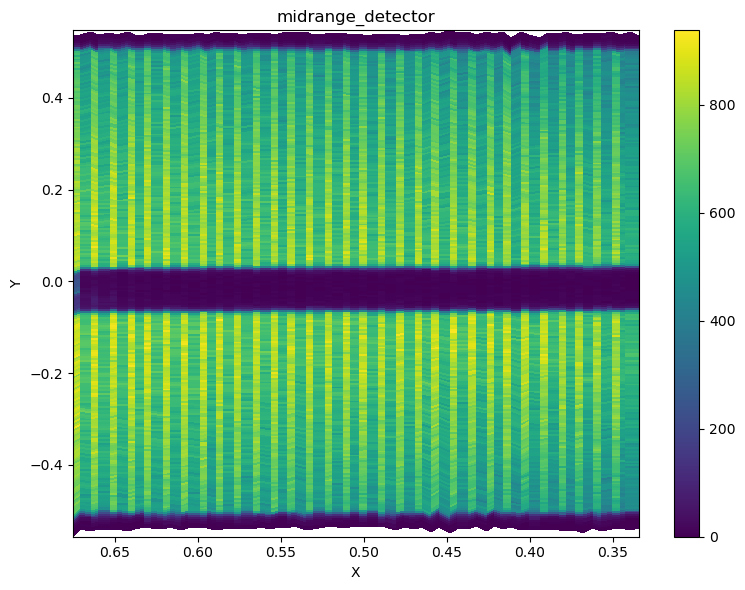

In [28]:
plot_main_detector('CG3_22544', axes_mode='xy')
plot_wing_detector('CG3_22544', axes_mode='xy')
plot_midrange_detector('CG3_22544', axes_mode='xy')

<h3>Calculate Tube Width Calibration</h3>

Relevant function is [calculate_apparent_tube_width](http://docs.drt-sans.ornl.gov/drtsans/pixel_calibration.html#drtsans.pixel_calibration.calculate_apparent_tube_width)

In [29]:
import numpy as np
import os
import time
from mantid.simpleapi import LoadNexus
from drtsans.mono.biosans import calculate_apparent_tube_width, plot_detector

#
# "plot_main_detector", "plot_wing_detector" and "plot_midrange_detector" are used to plot both detectors separately
#
%matplotlib inline
def plot_main_detector(input_workspace, axes_mode='xy', panel_name='detector1'):
    return plot_detector(input_workspace, backend='mpl',axes_mode=axes_mode,
                         panel_name=panel_name, imshow_kwargs={})
def plot_wing_detector(input_workspace, axes_mode='xy', panel_name='wing_detector'):
    return plot_detector(input_workspace, backend='mpl',axes_mode=axes_mode,
                         panel_name=panel_name, imshow_kwargs={})
def plot_midrange_detector(input_workspace, axes_mode='xy', panel_name='midrange_detector'):
    return plot_detector(input_workspace, backend='mpl',axes_mode=axes_mode,
                         panel_name=panel_name, imshow_kwargs={})
def plot_workspace(input_workspace, axes_mode='xy'):
    return plot_detector(input_workspace, backend='mpl',axes_mode=axes_mode, imshow_kwargs={})

The flood data is 8.7GB in size but we only need the integrated intensities per pixel. This only needs to be ran once, Thus:


In [30]:
"""
from drtsans.mono.biosans.simulated_intensities import clone_component_intensities, insert_midrange_detector
from mantid.api import AnalysisDataService
from mantid.simpleapi import mtd, DeleteWorkspace, DeleteWorkspaces, Integration, LoadEventNexus, SaveNexus
import os

flood_file = '/HFIR/CG3/IPTS-24666/nexus/CG3_22610.nxs.h5'
LoadEventNexus(Filename=flood_file, OutputWorkspace='in_flood')
Integration(InputWorkspace='in_flood', OutputWorkspace='in_flood')
insert_midrange_detector('in_flood', output_workspace='out_flood')
clone_component_intensities('out_flood',
                            input_component="wing_detector",
                            output_component="midrange_detector")
flood_file = '/SNS/EQSANS/shared/sans-backend/data/ornl/sans/hfir/biosans/pixel_calibration/midrange_22487/flood_file/CG3_22610.nxs'
SaveNexus(InputWorkspace='out_flood', Filename=flood_file)
DeleteWorkspaces(['in_flood', 'out_flood'])
"""

'\nfrom drtsans.mono.biosans.simulated_intensities import clone_component_intensities, insert_midrange_detector\nfrom mantid.api import AnalysisDataService\nfrom mantid.simpleapi import mtd, DeleteWorkspace, DeleteWorkspaces, Integration, LoadEventNexus, SaveNexus\nimport os\n\nflood_file = \'/HFIR/CG3/IPTS-24666/nexus/CG3_22610.nxs.h5\'\nLoadEventNexus(Filename=flood_file, OutputWorkspace=\'in_flood\')\nIntegration(InputWorkspace=\'in_flood\', OutputWorkspace=\'in_flood\')\ninsert_midrange_detector(\'in_flood\', output_workspace=\'out_flood\')\nclone_component_intensities(\'out_flood\',\n                            input_component="wing_detector",\n                            output_component="midrange_detector")\nflood_file = \'/SNS/EQSANS/shared/sans-backend/data/ornl/sans/hfir/biosans/pixel_calibration/midrange_22487/flood_file/CG3_22610.nxs\'\nSaveNexus(InputWorkspace=\'out_flood\', Filename=flood_file)\nDeleteWorkspaces([\'in_flood\', \'out_flood\'])\n'

In [31]:
flood_file = '/SNS/EQSANS/shared/sans-backend/data/ornl/sans/hfir/biosans/pixel_calibration/midrange_22487/flood_file/CG3_22610.nxs'
LoadNexus(Filename=flood_file, OutputWorkspace='flood_workspace')

ISISRunLogs-[Warning] Cannot find period log. Logs will be not be filtered by current period
ISISRunLogs-[Warning] Cannot find periods log. Logs will be not be filtered by current period


Workspace2D
Title: Panel Scan 4 of 4,   smpl: Flood H2O 1mm
Histograms: 106496
Bins: 1
Histogram
X axis: Time-of-flight / microsecond
Y axis: Counts
Distribution: False
Instrument: BIOSANS (2023-Oct-01 to 2100-Dec-31)Instrument from: /SNS/EQSANS/shared/sans-backend/data/ornl/sans/hfir/biosans/pixel_calibration/midrange_22487/CG3_22544.nxs

Run start: 2024-Jan-19 22:42:53
Run end:  2024-Jan-20 03:42:53

The main detector needs the beam center to be masked prior to running the tube width calibration.

We have masked the beam center and saved the mask in a file. Here we apply the mask to the workspace using `apply_mask`

In [33]:
from drtsans.mono.biosans import apply_mask
mask_file = '/SNS/EQSANS/shared/sans-backend/data/ornl/sans/hfir/biosans/pixel_calibration/midrange_5767/flood_file/mask_5904.xml'
apply_mask('flood_workspace', mask=mask_file)

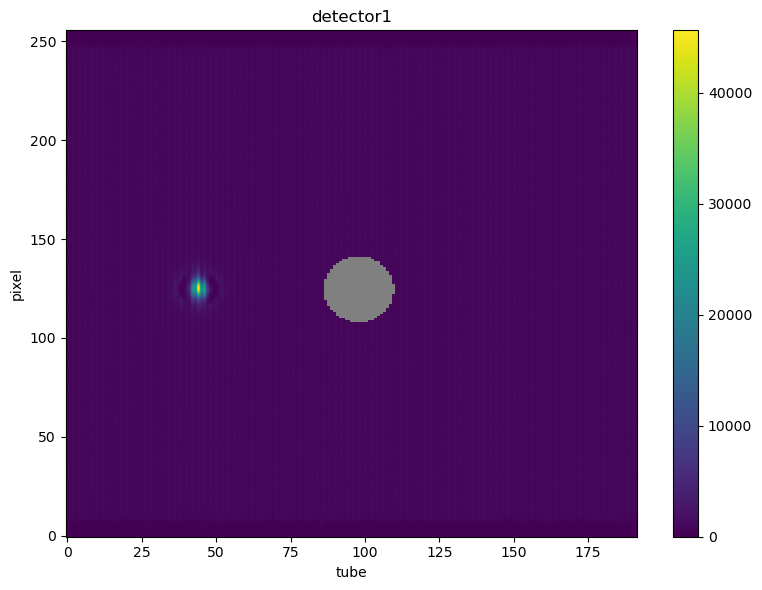

In [34]:
plot_main_detector('flood_workspace', axes_mode='tube-pixel')

Ideally, calculation of the apparent tube width requires that the pixel positions and heights have been calibrated with a barscan. If no good barscan is present in the database, we can bypass applying the bar scan with option `load_barscan_calibration=False`.

In [35]:
from drtsans.mono.biosans import calculate_apparent_tube_width

start_time = time.time()
calibration_main = calculate_apparent_tube_width(
    'flood_workspace', component='detector1',
    load_barscan_calibration=True, db_file='/tmp/pixel_calibration.json')
calibration_wing = calculate_apparent_tube_width(
    'flood_workspace', component='wing_detector',
    load_barscan_calibration=True, db_file='/tmp/pixel_calibration.json')
calibration_midrange = calculate_apparent_tube_width(
    'flood_workspace', component='midrange_detector',
    load_barscan_calibration=True, db_file='/tmp/pixel_calibration.json')

print('Calibration took ', int(time.time() - start_time), 'seconds')

Calibration took  2 seconds


<h5>Calibration objects are saved to a database as two separate pieces:</h5>

- metadata (instrument name, day stamp, name of the double-detector-array) is save to a JSON file.  
- data (a table workspace) is saved to a Nexus file with SaveNexus.  

There's a default database for every instrument. The BIOSANS location for the metadata JSON file:

- BIOSANS: <b>/HFIR/CG3/shared/calibration/pixel_calibration.json</b>

Data tables are saved under `tables/` subdirectory:

- BIOSANS: <b>/HFIR/CG3/shared/calibration/tables</b>

<h5>Calibration objects have method "<b>save</b>" to save itself to the the database. The full signature of this method:</h5>

    def save(self, database=None, tablefile=None, overwrite=False):
        r"""
        Save the calibration metadata in a JSON file, and the calibration table workspace in a Nexus file.

        Parameters
        ----------
        database: str
            Path to the JSON file where the ```metadata``` dictionary will be appended. If :py:obj:`None`,
            then the appropriate default file from ~drtsans.pixel_calibration.database_file is used.
            Currently, these are the default files:
            - BIOSANS, '/HFIR/CG3/shared/calibration/pixel_calibration.json',
            - EQSANS, '/SNS/EQSANS/shared/calibration/pixel_calibration.json',
            - GPSANS, '/HFIR/CG2/shared/calibration/pixel_calibration.json'
        tablefile: str
            Path to the Nexus file storing the pixel calibration data. If :py:obj:`None`, then
            a composite name is created using the calibration type, instrument, component,
            and daystamp. (e.g. "barscan_biosans_detector1_20200311"). The file is saved under
            subdirectory 'tables', located within the directory of the ```database``` file.
            For instance, '/HFIR/CG3/shared/calibration/tables/barscan_biosans_detector1_20200311.nxs'
        overwrite: bool
            Substitute existing entry with same metadata

        Raises
        ------
        ValueError
            If we save a calibration already in the database with option ```overwrite=False```.
        """

In [36]:
calibration_main.save(database="/tmp/pixel_calibration.json", overwrite=True)  # save calibrations in the default database
calibration_wing.save(database="/tmp/pixel_calibration.json", overwrite=True)
calibration_midrange.save(database="/tmp/pixel_calibration.json", overwrite=True)

<h3>Load and Apply a Tube Width Calibration</h3>

First some general imports and a couple of custom plotting functions

In [37]:
import time
from mantid.api import mtd
from mantid.simpleapi import CreateWorkspace, LoadNexus
from drtsans.tubecollection import TubeCollection
from matplotlib import pyplot as plt
#
# "plot_histograms" to create fancy plots of the spectram stored in an input workspace
#
def plot_histograms(input_workspace, legend=[], xlabel='X-axis', ylabel='Y-axis', title='', linewidths=[]):
    r"""Line plot for the histograms of a workspace"""
    workspace = mtd[str(input_workspace)]
    number_histograms = workspace.getNumberHistograms()
    if len(legend) != number_histograms:
        legend = [str(i) for i in range(number_histograms)]
    if len(linewidths) != number_histograms:
        linewidths = [1] * number_histograms
    fig, ax = plt.subplots(subplot_kw={'projection':'mantid'})
    for workspace_index in range(number_histograms):
        ax.plot(workspace, wkspIndex=workspace_index, label=legend[workspace_index],
                linewidth=linewidths[workspace_index])
    ax.legend()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.tick_params(axis='x', direction='in')
    ax.tick_params(axis='y', direction='out')
    ax.grid(True)
    fig.show()

In [38]:
# Load the run to which we will apply the calibration, then plot the pixel intensities
from drtsans.mono.biosans import apply_mask

input_data = '/SNS/EQSANS/shared/sans-backend/data/ornl/sans/hfir/biosans/pixel_calibration/midrange_22487/flood_file/CG3_22610.nxs'

LoadNexus(Filename=input_data, OutputWorkspace='workspace')
mask_file = '/SNS/EQSANS/shared/sans-backend/data/ornl/sans/hfir/biosans/pixel_calibration/midrange_5767/flood_file/mask_5904.xml'
apply_mask('workspace', mask=mask_file)

ISISRunLogs-[Warning] Cannot find period log. Logs will be not be filtered by current period
ISISRunLogs-[Warning] Cannot find periods log. Logs will be not be filtered by current period


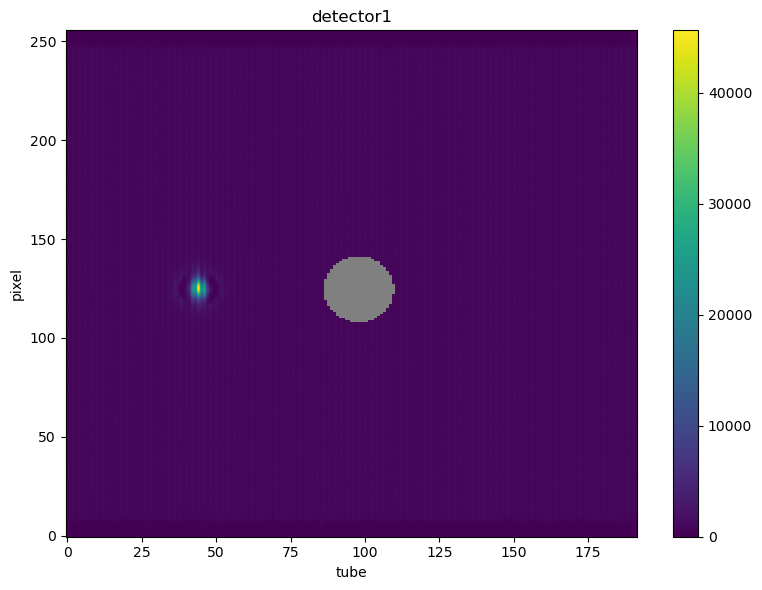

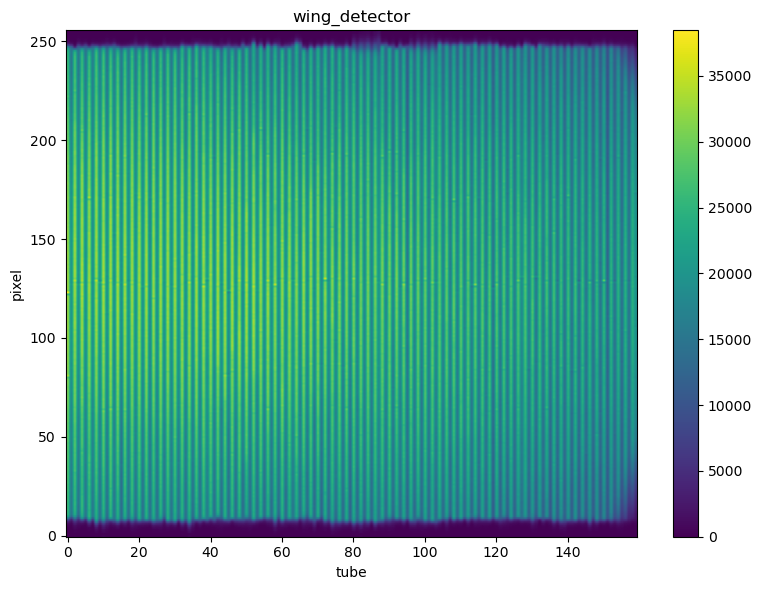

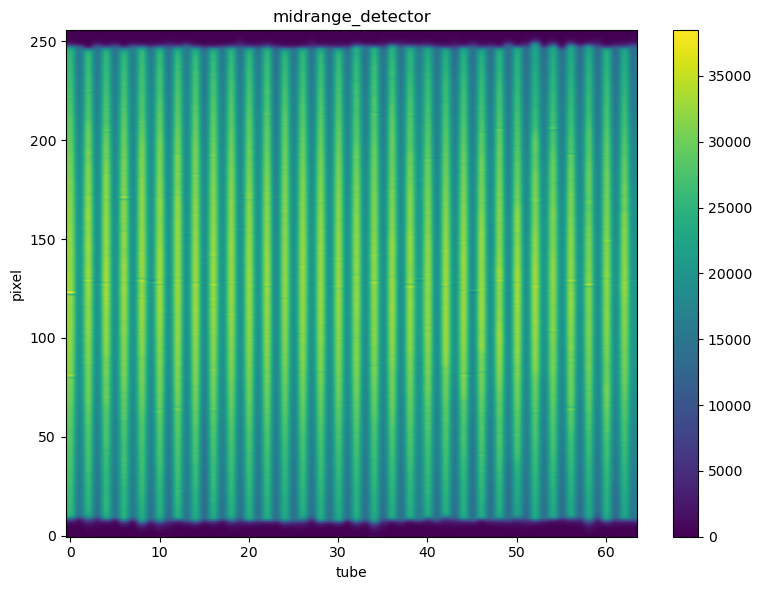

In [39]:
plot_main_detector('workspace', axes_mode='tube-pixel')
plot_wing_detector('workspace', axes_mode='tube-pixel')
plot_midrange_detector('workspace', axes_mode='tube-pixel')

The run corresponds to a flood run, and we have masked the beam center.

<h4>Intensities Normalized by Pixel Width</h4>
In function <code>linear_density</code> we integrate the total intensity per tube and divide by the number of non-masked pixels in the tube, and by the tube width. Front end tubes collect more intentity than the back tubes. Similarly, front end tubes have a larger apparent tube width than back tubes. The ratio of total intensity to width should be similar for front and end tubes after the calibration.

In [40]:
def linear_density(workspace, component='detector1'):
    r"""Tube total intensity per unit length of tube width"""
    collection = TubeCollection(workspace, component).sorted(view='decreasing X')
    intensities = np.array([np.sum(tube.readY) for tube in collection])
    widths = np.array([tube.width for tube in collection])
    number_pixels_not_masked = np.array([np.sum(~tube.isMasked) for tube in collection])
    return list(intensities / (number_pixels_not_masked * widths))

uncalibrated_main_densities = linear_density('workspace', component='detector1')
uncalibrated_wing_densities = linear_density('workspace', component='wing_detector')
uncalibrated_midrange_densities = linear_density('workspace', component='midrange_detector')

We store both linear densities in a workspace, and then we'll use matplotlib to plot both densities.

Next, we load and apply the calibration to each detector. We don't apply the `BARSCAN` calibration here, but just the `TUBEWIDTH` calibration.

In [41]:
from drtsans.mono.biosans import apply_calibrations

apply_calibrations('workspace', database="/tmp/pixel_calibration.json", calibrations='TUBEWIDTH')
calibrated_main_densities = linear_density('workspace', component='detector1')
calibrated_wing_densities = linear_density('workspace', component='wing_detector')
calibrated_midrange_densities = linear_density('workspace', component='midrange_detector')

We store both linear densities in a workspace, and then we'll use matplotlib to plot both densities

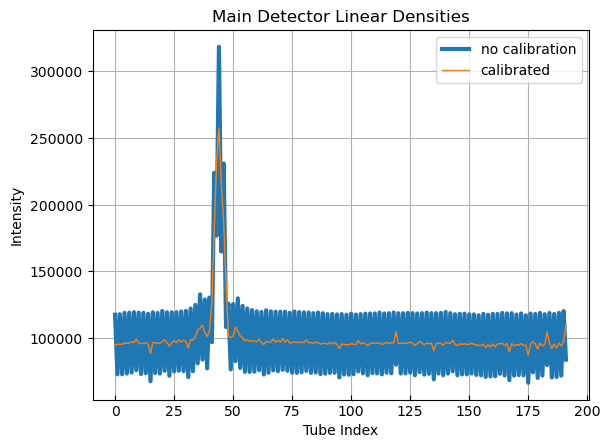

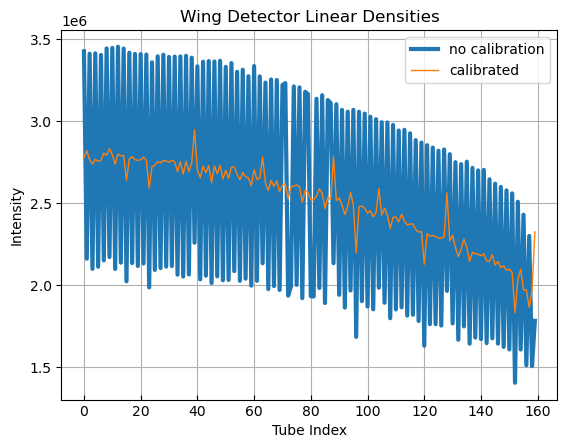

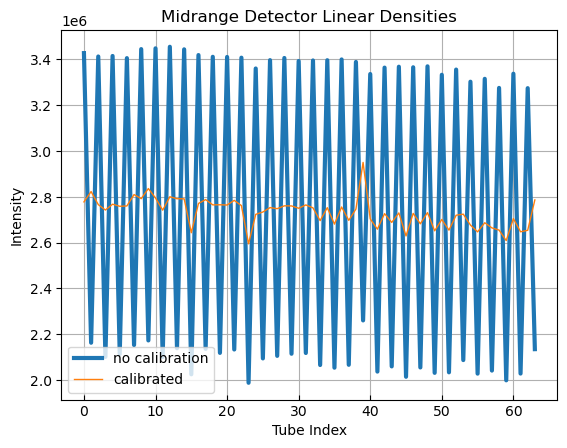

In [42]:
number_tubes = len(uncalibrated_main_densities)
CreateWorkspace(DataX=range(number_tubes),
                DataY=np.array([uncalibrated_main_densities, calibrated_main_densities]),
                NSpec=2,   # two histograms
                Outputworkspace='main_linear_densities')
plot_histograms('main_linear_densities', title='Main Detector Linear Densities',
                legend=['no calibration', 'calibrated'],
                xlabel='Tube Index', ylabel='Intensity', linewidths=[3, 1])

number_tubes = len(uncalibrated_wing_densities)
CreateWorkspace(DataX=range(number_tubes),
                DataY=np.array([uncalibrated_wing_densities, calibrated_wing_densities]),
                NSpec=2,   # two histograms
                Outputworkspace='wing_linear_densities')
plot_histograms('wing_linear_densities', title='Wing Detector Linear Densities',
                legend=['no calibration', 'calibrated'],
                xlabel='Tube Index', ylabel='Intensity', linewidths=[3, 1])

number_tubes = len(uncalibrated_midrange_densities)
CreateWorkspace(DataX=range(number_tubes),
                DataY=np.array([uncalibrated_midrange_densities, calibrated_midrange_densities]),
                NSpec=2,   # two histograms
                Outputworkspace='midrange_linear_densities')
plot_histograms('midrange_linear_densities', title='Midrange Detector Linear Densities',
                legend=['no calibration', 'calibrated'],
                xlabel='Tube Index', ylabel='Intensity', linewidths=[3, 1])

The oscillating intensities in the linear densities have been suppresed for most tubes, indicating the calibration is working.

<h3>Loading and Applying a pixel calibration</h3>

Relevant function is [apply_calibrations](http://docs.drt-sans.ornl.gov/drtsans/pixel_calibration.html#drtsans.pixel_calibration.apply_calibrations), which will search for <code>BARSCAN</code> and <code>TUBEWIDTH</code> calibrations appropriate to the target run

In [43]:
import time
from mantid.simpleapi import LoadNexus
from drtsans.mono.biosans import apply_calibrations

#
# "plot_workspace" is a utility function, which we will use a couple of times
#
from drtsans.plots import plot_detector
def plot_workspace(input_workspace, axes_mode='tube-pixel'):
    return plot_detector(input_workspace, backend='mpl',axes_mode=axes_mode, imshow_kwargs={})

In [44]:
# Load the run to which we will apply the calibration, then plot the pixel intensities
from drtsans.mono.biosans import apply_mask

input_data = '/SNS/EQSANS/shared/sans-backend/data/ornl/sans/hfir/biosans/pixel_calibration/midrange_22487/flood_file/CG3_22610.nxs'
LoadNexus(Filename=input_data, OutputWorkspace='workspace')
mask_file = '/SNS/EQSANS/shared/sans-backend/data/ornl/sans/hfir/biosans/pixel_calibration/midrange_5767/flood_file/mask_5904.xml'
apply_mask('workspace', mask=mask_file)

ISISRunLogs-[Warning] Cannot find period log. Logs will be not be filtered by current period
ISISRunLogs-[Warning] Cannot find periods log. Logs will be not be filtered by current period


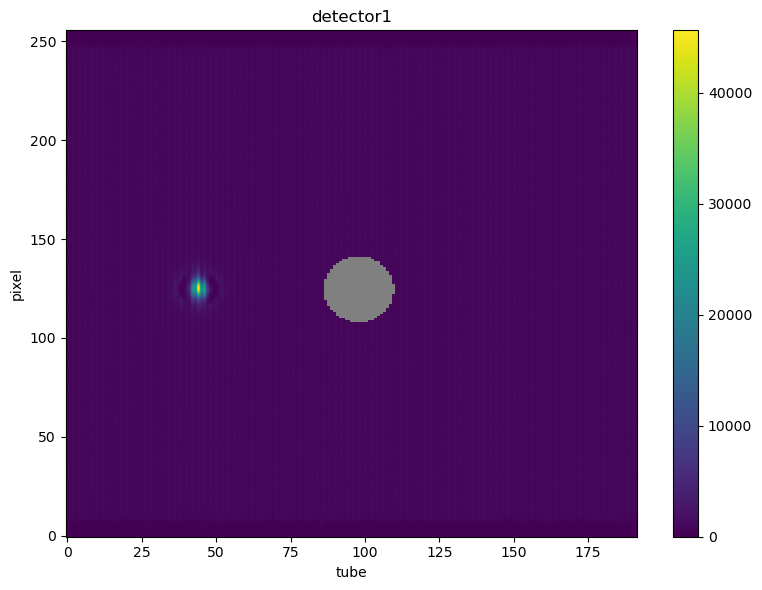

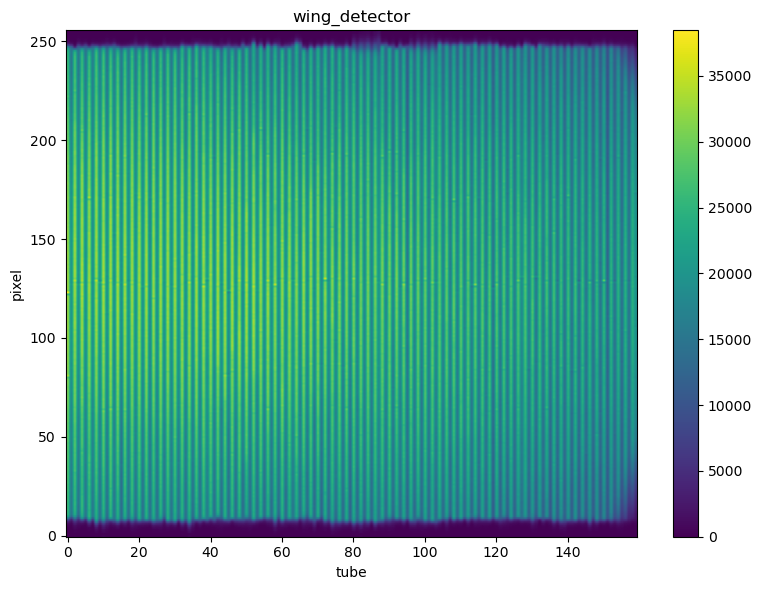

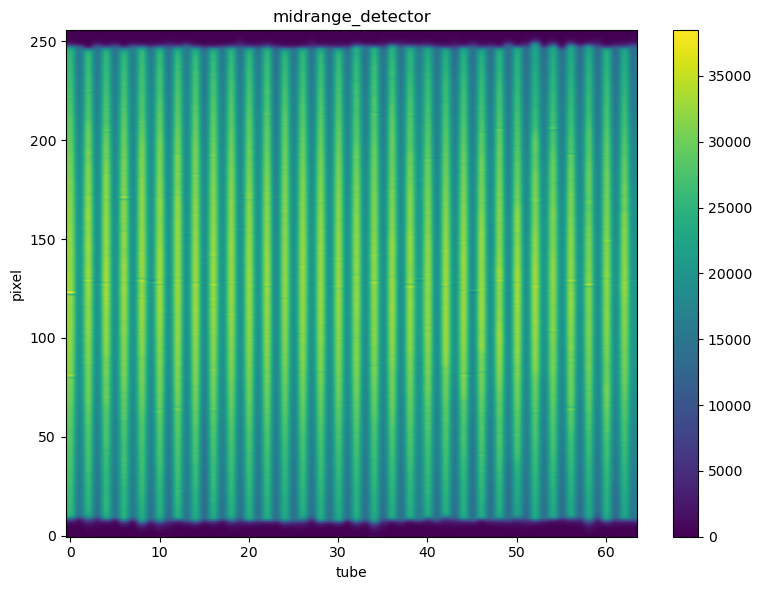

In [45]:
plot_main_detector('workspace', axes_mode='tube-pixel')
plot_wing_detector('workspace', axes_mode='tube-pixel')
plot_midrange_detector('workspace', axes_mode='tube-pixel')

In [46]:
start_time = time.time()
apply_calibrations('workspace', database="/tmp/pixel_calibration.json")  # apply both BARSCAN  TUBEWIDTH
print('Applying the calibration took ', time.time() - start_time, 'seconds')

Applying the calibration took  0.2770044803619385 seconds


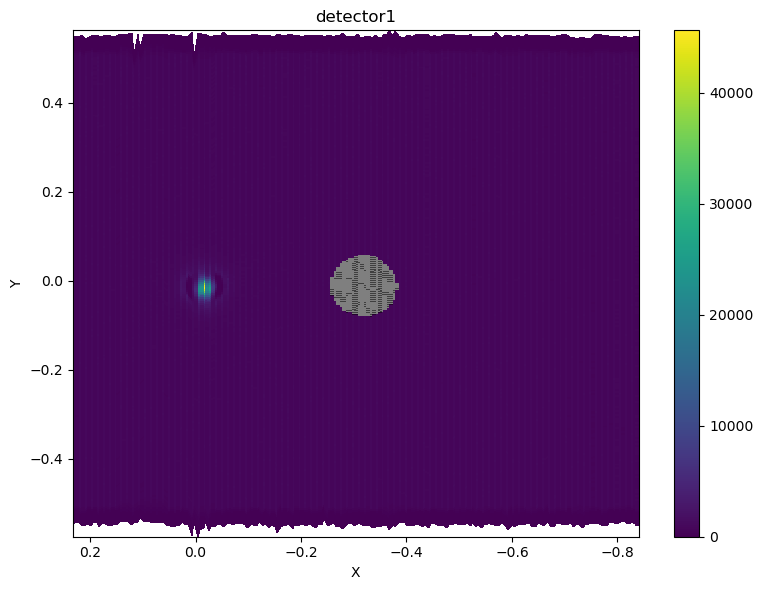

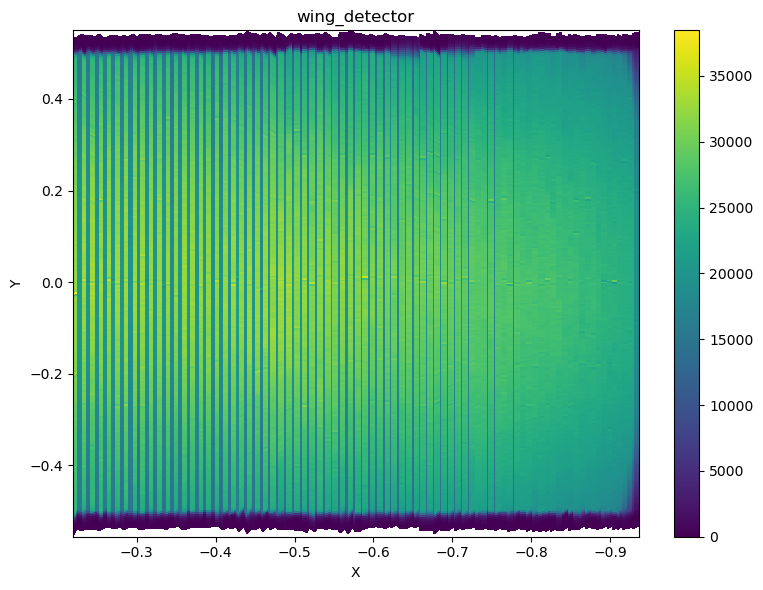

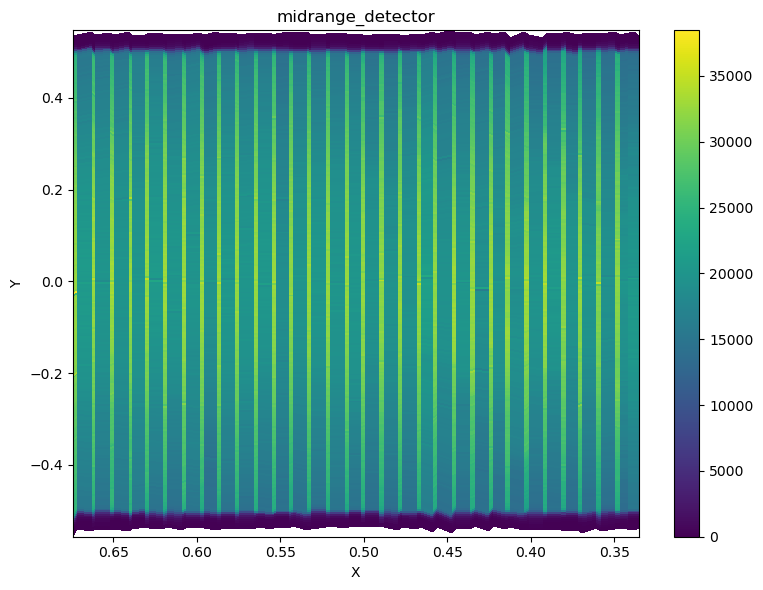

In [47]:
plot_main_detector('workspace', axes_mode='xy')
plot_wing_detector('workspace', axes_mode='xy')
plot_midrange_detector('workspace', axes_mode='xy')

We can see when the BARSCAN calibration was taken, and the time when the input data was taken. For this we use function [load_calibration](http://docs.drt-sans.ornl.gov/drtsans/pixel_calibration.html#drtsans.pixel_calibration.load_calibration) and function <code>day_stamp</code>.

In [48]:
from drtsans.pixel_calibration import load_calibration, day_stamp
barscan_calibration = load_calibration('workspace', 'BARSCAN')
tubewidth_calibration = load_calibration('workspace', 'TUBEWIDTH')
print('BARSCAN taken on', barscan_calibration.daystamp)
print('TUBEWIDTH taken on', tubewidth_calibration.daystamp)
print('Input data taken on ', day_stamp('workspace'))

BARSCAN taken on 20240119
TUBEWIDTH taken on 20230830
Input data taken on  20240119
